In [1]:
# %pip install pip-tools
# %pip install ipywidgets

In [2]:
# !pip-compile --strip-extras requirements.in
# %pip install -r requirements.txt

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader
from torchaudio.datasets import LIBRISPEECH

# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset LibriSpeech (dev-clean)
train_dataset = LIBRISPEECH("./datasets", url="dev-clean", download=False) # Jika blm punya dataset, bisa set True
test_dataset = LIBRISPEECH("./datasets", url="test-clean", download=False)

In [8]:
# Preprocessing fungsi: ekstrak Mel Spectrogram dari audio
# Peringatan: n_mels=128 mungkin terlalu besar untuk n_fft=400 (n_freqs=201)
# Jika ingin menghilangkan warning, bisa turunkan n_mels (misal 80) atau naikkan n_fft
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_mels=80,  # ubah dari 128 ke 80 agar tidak ada filterbank yang nol
    n_fft=400,
    hop_length=160,
).to(device)

# Buat collate_fn untuk padding batch data audio dan teks
def collate_fn(batch):
    waveforms = []
    labels = []
    input_lengths = []
    label_lengths = []

    for waveform, sample_rate, transcript, _, _, _ in batch:
        waveform = waveform.to(device)
        # ekstrak fitur
        mel_spec = mel_spectrogram(waveform).squeeze(0).transpose(0, 1)  # (time, mel)
        waveforms.append(mel_spec)

        # ubah transcript ke label index
        label = text_to_index(transcript.lower())
        labels.append(torch.tensor(label, dtype=torch.long))

        input_lengths.append(mel_spec.shape[0])
        label_lengths.append(len(label))

    # Pad input fitur (waveforms) dan label (teks)
    waveforms = nn.utils.rnn.pad_sequence(waveforms, batch_first=True)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)

    return waveforms, labels, torch.tensor(input_lengths), torch.tensor(label_lengths)

# Map karakter ke index (tokenizer sederhana)
char_map_str = " abcdefghijklmnopqrstuvwxyz'"
char_map = {c: i + 1 for i, c in enumerate(char_map_str)}  # 0 untuk padding

def text_to_index(text):
    return [char_map.get(c, 0) for c in text]

def index_to_text(indices):
    inv_map = {v: k for k, v in char_map.items()}
    return "".join([inv_map.get(i, "") for i in indices])

# Dataset dan DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [10]:
# Model RNN sederhana dengan CTC Loss
class SpeechRecognitionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # bidirectional

    def forward(self, x):
        # x: (batch, time, feat)
        out, _ = self.rnn(x)
        out = self.fc(out)  # (batch, time, output_dim)
        return out.log_softmax(dim=-1)

input_dim = 80  # disesuaikan dengan n_mels pada mel_spectrogram
hidden_dim = 256
output_dim = len(char_map) + 1  # plus blank token untuk CTC

model = SpeechRecognitionModel(input_dim, hidden_dim, output_dim).to(device)

# Loss function CTC
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop dengan print progress
def train_epoch():
    model.train()
    total_loss = 0
    for batch_idx, (waveforms, labels, input_lengths, label_lengths) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = model(waveforms)  # (batch, time, output_dim)
        outputs = outputs.transpose(0, 1)  # CTC expects (time, batch, output)

        loss = ctc_loss(outputs, labels, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print(f"Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch selesai. Rata-rata loss: {avg_loss:.4f}")
    return avg_loss

# Inference decode: greedy decoding (ambil argmax di output)
def greedy_decoder(output):
    argmaxes = torch.argmax(output, dim=-1)
    decoded_batch = []
    for args in argmaxes:
        decoded = []
        prev = 0
        for i in args:
            if i != prev and i != 0:
                decoded.append(i.item())
            prev = i
        decoded_batch.append(index_to_text(decoded))
    return decoded_batch

# Jalankan training
print("Training mulai...")
train_loss = train_epoch()
print(f"Training loss: {train_loss:.4f}")

Training mulai...
Batch 1/16 - Loss: 19.6441
Batch 2/16 - Loss: 20.1134
Batch 3/16 - Loss: 17.4877
Batch 4/16 - Loss: 9.2388
Batch 5/16 - Loss: 5.0349
Batch 6/16 - Loss: 3.4616
Batch 7/16 - Loss: 5.6208
Batch 8/16 - Loss: 5.5928
Batch 9/16 - Loss: 5.0473
Batch 10/16 - Loss: 4.5530
Batch 11/16 - Loss: 3.7796
Batch 12/16 - Loss: 3.2339
Batch 13/16 - Loss: 3.3254
Batch 14/16 - Loss: 3.3568
Batch 15/16 - Loss: 3.2903
Batch 16/16 - Loss: 3.2079
Epoch selesai. Rata-rata loss: 7.2493
Training loss: 7.2493


In [ ]:
import pickle

with open("speech_recognition_model.pkl", "wb") as f:
    pickle.dump(model, f)
print("Model berhasil disimpan ke speech_recognition_model.pkl")

In [4]:
import pickle

with open("speech_recognition_model.pkl", "rb") as f:
    model = pickle.load(f)
print("Model berhasil dimuat dari speech_recognition_model.pkl")

Model berhasil dimuat dari speech_recognition_model.pkl


In [11]:
# Simple evaluation loop
def evaluate():
    model.eval()
    with torch.no_grad():
        for waveforms, labels, input_lengths, label_lengths in test_loader:
            outputs = model(waveforms)
            decoded_preds = greedy_decoder(outputs)
            for pred in decoded_preds[:5]:  # tampilkan 5 hasil prediksi
                print("Prediksi:", pred)
            break

print("Evaluasi contoh prediksi...")
evaluate()

Evaluasi contoh prediksi...
Prediksi: 
Prediksi: 
Prediksi: 
Prediksi: 
Prediksi: 


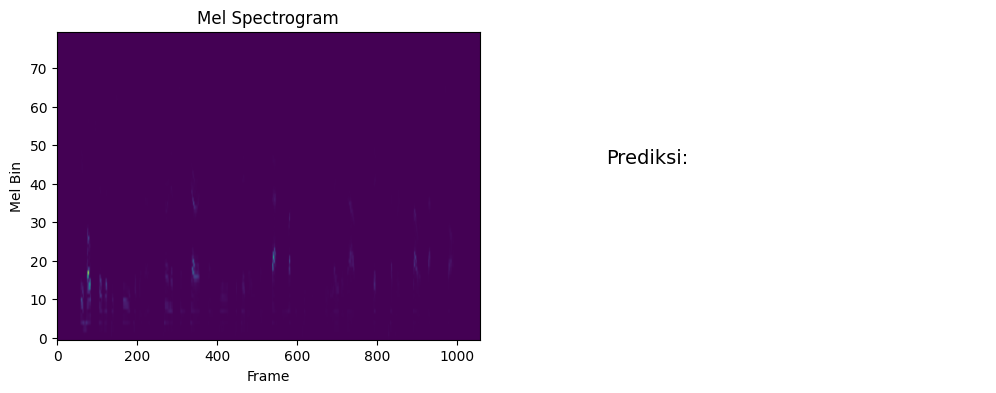

In [12]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for waveforms, labels, input_lengths, label_lengths in test_loader:
        outputs = model(waveforms)
        decoded_preds = greedy_decoder(outputs)
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        # Plot Mel Spectrogram dari sample pertama di batch
        axes[0].imshow(waveforms[0].cpu().T, aspect='auto', origin='lower')
        axes[0].set_title("Mel Spectrogram")
        axes[0].set_xlabel("Frame")
        axes[0].set_ylabel("Mel Bin")
        # Tampilkan prediksi hasil decoding
        axes[1].axis('off')
        axes[1].text(0.1, 0.5, f"Prediksi:\n{decoded_preds[0]}", fontsize=14)
        plt.show()
        break